
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase1<br>
    Image Segmentation<br>
<font color=696880 size=4>
    Shayan Baghayi Nejad-Armin Khosravi


<font size=5 color=cyan> Names:
Amirparsa Safari, Mohammadhasan Shafaat, Mohammad Mahdi Mohammadi

Student Numbers:  402171007, 402106134, 402106456
</font>

# Introduction

In this Project, we will become familiar with UNet architecture, Attention mechanism, and Residual blocks with the help of which we will build UNet, AttentionUNet, and ResidualAttentionUnet from scratch using PyTorch framework. The built models will be evaluated by various metrics such as accuracy, Iou score, and Dice score.

### Environment Setup

Here you will find the required packages. Feel free to add the list.

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import kagglehub
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

### Hyperparameter Setting

Place your hyperparameters' values in the cell below.

In [ ]:
DATA_DIR = '/content/drive/MyDrive/1/'
IMAGE_SIZE = (1500, 1500)
BATCH_SIZE = 16
NUM_WORKERS = 2
LR = 1e-4
NUM_EPOCHS = 50

# Data Preparation

Our task is to segment the [Massachusetts Road Dataset](https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset). You can download this dataset by placing your API Token from kaggle in ```~/.kaggle/``` folder (Instructions can be found in the Kaggle website) and then running the code below.

If you are running on colab, it is highly recommended to save the dataset to your drive to avoid problems when disconnecting from runtime.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# shutil.move(path, '/content/drive/MyDrive/')

Mounted at /content/drive


### Loading Images

Load the images and their corresponding masks in two separate lists. (The cell below might take some time to execute.)

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_size):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size

        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),  # Converts to [0,1] and CxHxW
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),  # Converts grayscale to [0,1]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        image = self.image_transform(image)
        mask = self.mask_transform(mask)

        return image, mask


In [ ]:
# File extension filter
valid_ext = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')

# Paths
train_images_dir = os.path.join(DATA_DIR, 'tiff/train')
train_masks_dir = os.path.join(DATA_DIR, 'tiff/train_labels')
val_images_dir = os.path.join(DATA_DIR, 'tiff/val')
val_masks_dir = os.path.join(DATA_DIR, 'tiff/val_labels')

# Lists of file paths
train_images_path = sorted([
    os.path.join(train_images_dir, f)
    for f in os.listdir(train_images_dir)
    if f.lower().endswith(valid_ext)
])
train_masks_path = sorted([
    os.path.join(train_masks_dir, f)
    for f in os.listdir(train_masks_dir)
    if f.lower().endswith(valid_ext)
])

val_images_path = sorted([
    os.path.join(val_images_dir, f)
    for f in os.listdir(val_images_dir)
    if f.lower().endswith(valid_ext)
])
val_masks_path = sorted([
    os.path.join(val_masks_dir, f)
    for f in os.listdir(val_masks_dir)
    if f.lower().endswith(valid_ext)
])

# Datasets
train_dataset = SegmentationDataset(train_images_path, train_masks_path, IMAGE_SIZE)
val_dataset = SegmentationDataset(val_images_path, val_masks_path, IMAGE_SIZE)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

### Data Visualization

Display the images and their masks for several samples.

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

def visualize_images_and_masks(images, masks, n=5):
    """
    Visualizes 'n' images and their corresponding masks side by side.

    Args:
        images (Tensor): Batch of input images (B, 3, H, W)
        masks (Tensor): Batch of corresponding masks (B, 1, H, W)
        n (int): Number of image-mask pairs to display
    """
    images = images[:n]
    masks = masks[:n]

    plt.figure(figsize=(10, 4 * n))

    for i in range(n):
        img = TF.to_pil_image(images[i])
        mask = TF.to_pil_image(masks[i])

        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title(f"Image {i + 1}")
        plt.axis('off')

        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get one batch from the DataLoader
images_batch, masks_batch = next(iter(train_loader))

# Visualize
visualize_images_and_masks(images_batch, masks_batch, n=5)


# UNet

Before proceeding, it is necessary to understand the idea behind UNet. In order to avoid too much details in this notebook, you can read the complete paper for UNet from [this link](https://arxiv.org/pdf/1505.04597).

The overall structure of UNet is provided in the image below.

![UNet Architecture](https://viso.ai/wp-content/uploads/2024/04/unet-process.png)

### Convolution Block

Convolution block is used at each level of UNet.

In [ ]:
class ConvBlock(nn.Module):
    """
    A convolutional block consisting of multiple layers (e.g., Conv2D, BatchNorm, ReLU).

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

### Up Convoluitional Block

We use another block to upsample the latent vector.

In [ ]:
class UpConvBlock(nn.Module):
    """
    An upsampling block used in decoder parts of segmentation networks like U-Net.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.upconv(x)

### Complete UNet Structure

Now using the ```ConvBlock``` and ```UpConvBlock``` you created, complete the UNet architecture.

In [ ]:
class UNet(nn.Module):
    """
    U-Net architecture for image segmentation tasks.

    Args:
        in_channel (int): Number of input channels (e.g., 3 for RGB images).
        out_channel (int): Number of output channels (e.g., 1 for binary segmentation).
        filter (list): List of filter sizes for each level of the encoder/decoder.
    """
    def __init__(self, in_channel=3, out_channel=1, filter=[64, 128, 256, 512]):
        super().__init__()

        # Encoder
        self.enc1 = ConvBlock(in_channel, filter[0])
        self.enc2 = ConvBlock(filter[0], filter[1])
        self.enc3 = ConvBlock(filter[1], filter[2])
        self.enc4 = ConvBlock(filter[2], filter[3])

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = ConvBlock(filter[3], filter[3] * 2)

        # Decoder
        self.upconv4 = UpConvBlock(filter[3] * 2, filter[3])
        self.dec4 = ConvBlock(filter[3] * 2, filter[3])

        self.upconv3 = UpConvBlock(filter[3], filter[2])
        self.dec3 = ConvBlock(filter[2] * 2, filter[2])

        self.upconv2 = UpConvBlock(filter[2], filter[1])
        self.dec2 = ConvBlock(filter[1] * 2, filter[1])

        self.upconv1 = UpConvBlock(filter[1], filter[0])
        self.dec1 = ConvBlock(filter[0] * 2, filter[0])

        # Output layer
        self.final_conv = nn.Conv2d(filter[0], out_channel, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final_conv(d1)

# Attention UNet

### Attention Mechanism

Attention UNet uses this mechanism to know what part the image is more important to attend to. You can read about this mechanism from [this link](https://arxiv.org/pdf/1706.03762). The Attention mechanism in UNet is described in [this paper](https://arxiv.org/pdf/1804.03999).


![Attention](https://www.researchgate.net/publication/373655981/figure/fig3/AS:11431281186315360@1693879045519/Visualization-of-attention-blocks-reveals-their-functionality-While-the-self-attention.png)

In [ ]:
class AttentionBlock(nn.Module):
    """
    Attention block for focusing on relevant features in skip connections.

    Args:
        f_g (int): Number of channels in the gating signal (from decoder).
        f_l (int): Number of channels in the skip connection input (from encoder).
        f_int (int): Number of intermediate channels used within the attention block.
    """
    def __init__(self, f_g, f_l, f_int):
        super().__init__()

        self.w_g = nn.Sequential(
            nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int)
        )

        self.w_x = nn.Sequential(
            nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.act = nn.ReLU(inplace=True)

    def forward(self, g, x):
        """
        Forward pass of the attention block.

        Args:
            g (Tensor): Decoder input (gating signal), shape (B, f_g, H, W).
            x (Tensor): Encoder feature map to be refined, shape (B, f_l, H, W).
        Returns:
            Tensor: Refined encoder features, same shape as x.
        """
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.act(g1 + x1)
        psi = self.psi(psi)
        return x * psi

Now use the ```AttentionBlock``` to inherit [Attention UNet](https://arxiv.org/pdf/1804.03999) from UNet.

![Attention UNet](https://www.researchgate.net/publication/347344899/figure/fig6/AS:971357475069952@1608601077414/The-architecture-of-Attention-U-Net-Attention-gate-selects-features-by-using-the.png)

In [ ]:
class AttentionUNet(UNet):  # Inherits from UNet
    """
    Attention U-Net architecture which extends the basic U-Net
    by integrating attention blocks in the skip connections.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
        filter_sizes (list): List of filter sizes for each level.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter_sizes)

        # Define attention blocks (g = decoder, x = encoder)
        self.att4 = AttentionBlock(f_g=filter_sizes[3], f_l=filter_sizes[3], f_int=filter_sizes[3] // 2)
        self.att3 = AttentionBlock(f_g=filter_sizes[2], f_l=filter_sizes[2], f_int=filter_sizes[2] // 2)
        self.att2 = AttentionBlock(f_g=filter_sizes[1], f_l=filter_sizes[1], f_int=filter_sizes[1] // 2)
        self.att1 = AttentionBlock(f_g=filter_sizes[0], f_l=filter_sizes[0], f_int=filter_sizes[0] // 2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder with attention-enhanced skip connections
        d4 = self.upconv4(b)
        e4_att = self.att4(g=d4, x=e4)
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))

        d3 = self.upconv3(d4)
        e3_att = self.att3(g=d3, x=e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))

        d2 = self.upconv2(d3)
        e2_att = self.att2(g=d2, x=e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.upconv1(d2)
        e1_att = self.att1(g=d1, x=e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        return self.final_conv(d1)

# Residual Attention UNet

We will add residual blocks to the attention for better gradient flow. You can read more about residual blocks [here](https://arxiv.org/pdf/1512.03385).

<img src="https://dfzljdn9uc3pi.cloudfront.net/2023/cs-1302/1/fig-1-full.png" width="400" alt="ResUNet Architecture">

In [ ]:
class ResidualConvBlock(nn.Module):
    """
    Residual convolutional block with skip connection.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )

        # Shortcut path: identity if same channels, otherwise 1x1 conv to match dims
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channel)
        ) if in_channel != out_channel else nn.Identity()

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual  # Add skip connection
        return self.relu(out)

Use ```ResidualConvBlock``` to construct Residual Attention Unet.

In [ ]:
class ResidualAttentionUNet(AttentionUNet):
    """
    Residual Attention U-Net combining residual blocks with attention mechanisms.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
        filter_sizes (list): List of filter sizes for each level.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super(AttentionUNet, self).__init__()

        # Encoder with Residual Blocks
        self.enc1 = ResidualConvBlock(in_channel, filter_sizes[0])
        self.enc2 = ResidualConvBlock(filter_sizes[0], filter_sizes[1])
        self.enc3 = ResidualConvBlock(filter_sizes[1], filter_sizes[2])
        self.enc4 = ResidualConvBlock(filter_sizes[2], filter_sizes[3])

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck with Residual Block
        self.bottleneck = ResidualConvBlock(filter_sizes[3], filter_sizes[3] * 2)

        # Decoder
        self.upconv4 = UpConvBlock(filter_sizes[3] * 2, filter_sizes[3])
        self.att4 = AttentionBlock(filter_sizes[3], filter_sizes[3], filter_sizes[3] // 2)
        self.dec4 = ResidualConvBlock(filter_sizes[3] * 2, filter_sizes[3])

        self.upconv3 = UpConvBlock(filter_sizes[3], filter_sizes[2])
        self.att3 = AttentionBlock(filter_sizes[2], filter_sizes[2], filter_sizes[2] // 2)
        self.dec3 = ResidualConvBlock(filter_sizes[2] * 2, filter_sizes[2])

        self.upconv2 = UpConvBlock(filter_sizes[2], filter_sizes[1])
        self.att2 = AttentionBlock(filter_sizes[1], filter_sizes[1], filter_sizes[1] // 2)
        self.dec2 = ResidualConvBlock(filter_sizes[1] * 2, filter_sizes[1])

        self.upconv1 = UpConvBlock(filter_sizes[1], filter_sizes[0])
        self.att1 = AttentionBlock(filter_sizes[0], filter_sizes[0], filter_sizes[0] // 2)
        self.dec1 = ResidualConvBlock(filter_sizes[0] * 2, filter_sizes[0])

        # Output
        self.final_conv = nn.Conv2d(filter_sizes[0], out_channel, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder with attention-gated skip connections
        d4 = self.upconv4(b)
        e4_att = self.att4(g=d4, x=e4)
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))

        d3 = self.upconv3(d4)
        e3_att = self.att3(g=d3, x=e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))

        d2 = self.upconv2(d3)
        e2_att = self.att2(g=d2, x=e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.upconv1(d2)
        e1_att = self.att1(g=d1, x=e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        return self.final_conv(d1)

# Training

Now it is time to train the model on training data.

### Loss Function

We will be using the sum of [Dice Score](https://oecd.ai/en/catalogue/metrics/dice-score#:~:text=The%20Dice%20score%20is%20calculated,sizes%20of%20the%20two%20sets.), [Iou Score](https://www.v7labs.com/blog/intersection-over-union-guide), and Binary Cross Entropy as loss function. You can read about the mentioned scores in the provided links.

<font color=cyan><b> Note: Do Not Change The ```OverallLoss``` Function as it is used for measuring you model's performance.</b></font>

In [ ]:
### DICE LOSS
class DiceLoss(nn.Module):
    """
    Dice Loss for measuring overlap between predicted and ground truth masks.
    Particularly useful for imbalanced classes in segmentation tasks.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.view(-1)
        real = real.view(-1)

        intersection = (pred * real).sum()
        dice_coeff = (2. * intersection + self.smooth) / (pred.sum() + real.sum() + self.smooth)
        return 1 - dice_coeff


### IOU LOSS
class IouLoss(nn.Module):
    """
    Intersection over Union (IoU) Loss for segmentation evaluation.
    Measures the overlap between predicted and ground truth masks.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(IouLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.view(-1)
        real = real.view(-1)

        intersection = (pred * real).sum()
        union = pred.sum() + real.sum() - intersection
        iou_coeff = (intersection + self.smooth) / (union + self.smooth)
        return 1 - iou_coeff



### Overall Loss (DO NOT CHANGE)
class OverallLoss(nn.Module):
    """
    Combined loss function that sums Dice loss, IoU loss, and Binary Cross-Entropy loss.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(OverallLoss, self).__init__()
        self.dice_loss = DiceLoss(smooth)
        self.iou_loss = IouLoss(smooth)
        self.bce_loss = nn.BCELoss()

    def forward(self, pred, real):
        dice = self.dice_loss(pred, real)
        iou = self.iou_loss(pred, real)
        bce = self.bce_loss(pred, real)

        return dice, iou, bce, dice+iou+bce

### Training Epoch

Complete the function below to train the model for one epoch.

In [ ]:
def train_one_epoch(model, optimizer, criterion, data_loader, scheduler=None, device='cuda'):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        criterion (nn.Module): Loss function to compute the loss.
        data_loader (DataLoader): DataLoader providing training batches.
        scheduler (optional): Learning rate scheduler.
        device (str): Device to run the training on ('cuda' or 'cpu').

    Returns:
        float: Average loss over the epoch.
    """

    total_loss = 0.0
    model.train()

    for i, (img, mask) in enumerate(tqdm(data_loader)):
        # Move the image and mask to device
        img = img.to(device)
        mask = mask.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        pred = model(img)
        pred = torch.sigmoid(pred)  # Ensure prediction is in [0, 1]

        # Compute loss
        dice, iou, bce, loss = criterion(pred, mask)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Learning rate scheduler
        if scheduler:
            scheduler.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

Design a function for evaluation after each training phase.

In [ ]:
def evaluate_model(model, criterion, data_loader, device='cuda'):
    """
    Evaluates the model on validation or test data.

    Args:
        model (nn.Module): The neural network model to evaluate.
        criterion (nn.Module): Loss function to compute evaluation metrics.
        data_loader (DataLoader): DataLoader providing evaluation batches.
        device (str): Device to run evaluation on ('cuda' or 'cpu').

    Returns:
        tuple: Average loss, average IoU score, and average Dice score over the dataset.
    """
    total_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0
    model.eval()

    with torch.no_grad():
        for i, (img, mask) in enumerate(tqdm(data_loader)):
            # Move the image and mask to device
            img = img.to(device)
            mask = mask.to(device)

            # Predict the mask
            pred = model(img)
            pred = torch.sigmoid(pred)

            # Compute the loss
            dice_loss, iou_loss, bce_loss, overall_loss = criterion(pred, mask)

            total_loss += overall_loss.item()
            iou_score += 1 - iou_loss.item()   # Convert IoU loss to score
            dice_score += 1 - dice_loss.item() # Convert Dice loss to score

        total_loss /= len(data_loader)
        iou_score /= len(data_loader)
        dice_score /= len(data_loader)

    return total_loss, iou_score, dice_score


# Model Training

### UNet  
Create an instance of UNet and train it. Then report the results.  

<b><font color=red>Note: your models need to satisfy below conditions to get complete score.</font></b>

<table style="width: 100%; font-size: 18px; border-collapse: collapse; margin: 15px 0;">
  <tr>
    <th style="text-align: left; padding: 8px; border-bottom: 2px solid #ddd;">Model</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Validation Loss</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Iou Score</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Dice Score</th>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 1.0</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.5</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">Attention UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 0.9</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.65</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Residual Attention UNet</td>
    <td style="text-align: right; padding: 8px;">&lt; 0.8</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.65</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.7</td>
  </tr>
</table>

In [ ]:
unet = UNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(unet.parameters(), lr=LR)
# Add a scheduler if you like

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(unet, criterion, val_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(unet.state_dict(), "best_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

Now do the same for Attention UNet and Reidual Attention UNet.

In [ ]:
attention_unet = AttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(attention_unet.parameters(), lr=LR)

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(attention_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(attention_unet, criterion, val_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(attention_unet.state_dict(), "best_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Iteration 1/15: Train Loss: 1.78 | Val Loss: 1.54 | Iou Score: 0.34 | Dice Score: 0.50


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Iteration 2/15: Train Loss: 1.30 | Val Loss: 1.16 | Iou Score: 0.47 | Dice Score: 0.64


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Iteration 3/15: Train Loss: 1.11 | Val Loss: 1.01 | Iou Score: 0.55 | Dice Score: 0.71


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Iteration 4/15: Train Loss: 1.04 | Val Loss: 0.91 | Iou Score: 0.58 | Dice Score: 0.73


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Iteration 5/15: Train Loss: 1.00 | Val Loss: 0.95 | Iou Score: 0.57 | Dice Score: 0.72


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Iteration 6/15: Train Loss: 0.97 | Val Loss: 0.86 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Iteration 7/15: Train Loss: 0.95 | Val Loss: 0.91 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Iteration 8/15: Train Loss: 0.94 | Val Loss: 0.86 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Iteration 9/15: Train Loss: 0.92 | Val Loss: 0.84 | Iou Score: 0.62 | Dice Score: 0.76


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Iteration 10/15: Train Loss: 0.91 | Val Loss: 0.80 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Iteration 11/15: Train Loss: 0.90 | Val Loss: 0.88 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Iteration 12/15: Train Loss: 0.89 | Val Loss: 0.79 | Iou Score: 0.63 | Dice Score: 0.78


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Iteration 13/15: Train Loss: 0.88 | Val Loss: 0.90 | Iou Score: 0.58 | Dice Score: 0.74


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Iteration 14/15: Train Loss: 0.87 | Val Loss: 0.79 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Iteration 15/15: Train Loss: 0.87 | Val Loss: 0.76 | Iou Score: 0.65 | Dice Score: 0.79


For Residual Attention UNet, plot the changes in train and validation loss.

In [ ]:
resattn_unet = ResidualAttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(resattn_unet.parameters(), lr=LR)

train_losses = []
val_losses = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(resattn_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(resattn_unet, criterion, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        torch.save(resattn_unet.state_dict(), "best_residual_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Iteration 1/15: Train Loss: 1.98 | Val Loss: 1.60 | Iou Score: 0.27 | Dice Score: 0.43


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Iteration 2/15: Train Loss: 1.42 | Val Loss: 1.17 | Iou Score: 0.45 | Dice Score: 0.62


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Iteration 3/15: Train Loss: 1.15 | Val Loss: 1.13 | Iou Score: 0.50 | Dice Score: 0.67


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Iteration 4/15: Train Loss: 1.04 | Val Loss: 0.95 | Iou Score: 0.57 | Dice Score: 0.72


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Iteration 5/15: Train Loss: 1.00 | Val Loss: 0.84 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Iteration 6/15: Train Loss: 0.97 | Val Loss: 0.85 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Iteration 7/15: Train Loss: 0.94 | Val Loss: 0.92 | Iou Score: 0.58 | Dice Score: 0.74


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Iteration 8/15: Train Loss: 0.93 | Val Loss: 0.86 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Iteration 9/15: Train Loss: 0.93 | Val Loss: 0.78 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Iteration 10/15: Train Loss: 0.91 | Val Loss: 0.82 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Iteration 11/15: Train Loss: 0.88 | Val Loss: 0.80 | Iou Score: 0.63 | Dice Score: 0.78


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Iteration 12/15: Train Loss: 0.87 | Val Loss: 0.84 | Iou Score: 0.62 | Dice Score: 0.77


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Iteration 13/15: Train Loss: 0.86 | Val Loss: 0.74 | Iou Score: 0.66 | Dice Score: 0.80


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Iteration 14/15: Train Loss: 0.86 | Val Loss: 0.77 | Iou Score: 0.65 | Dice Score: 0.79


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Iteration 15/15: Train Loss: 0.85 | Val Loss: 0.76 | Iou Score: 0.65 | Dice Score: 0.79


Now Visualize losses.

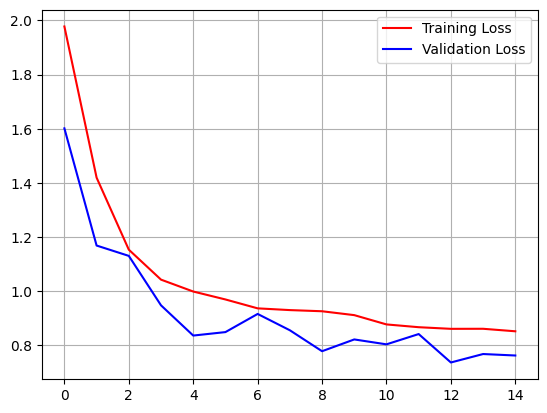

In [ ]:
# Plot the losses

### Prediction Visualisation

Display several images, their masks, and the predicted mask by your model.

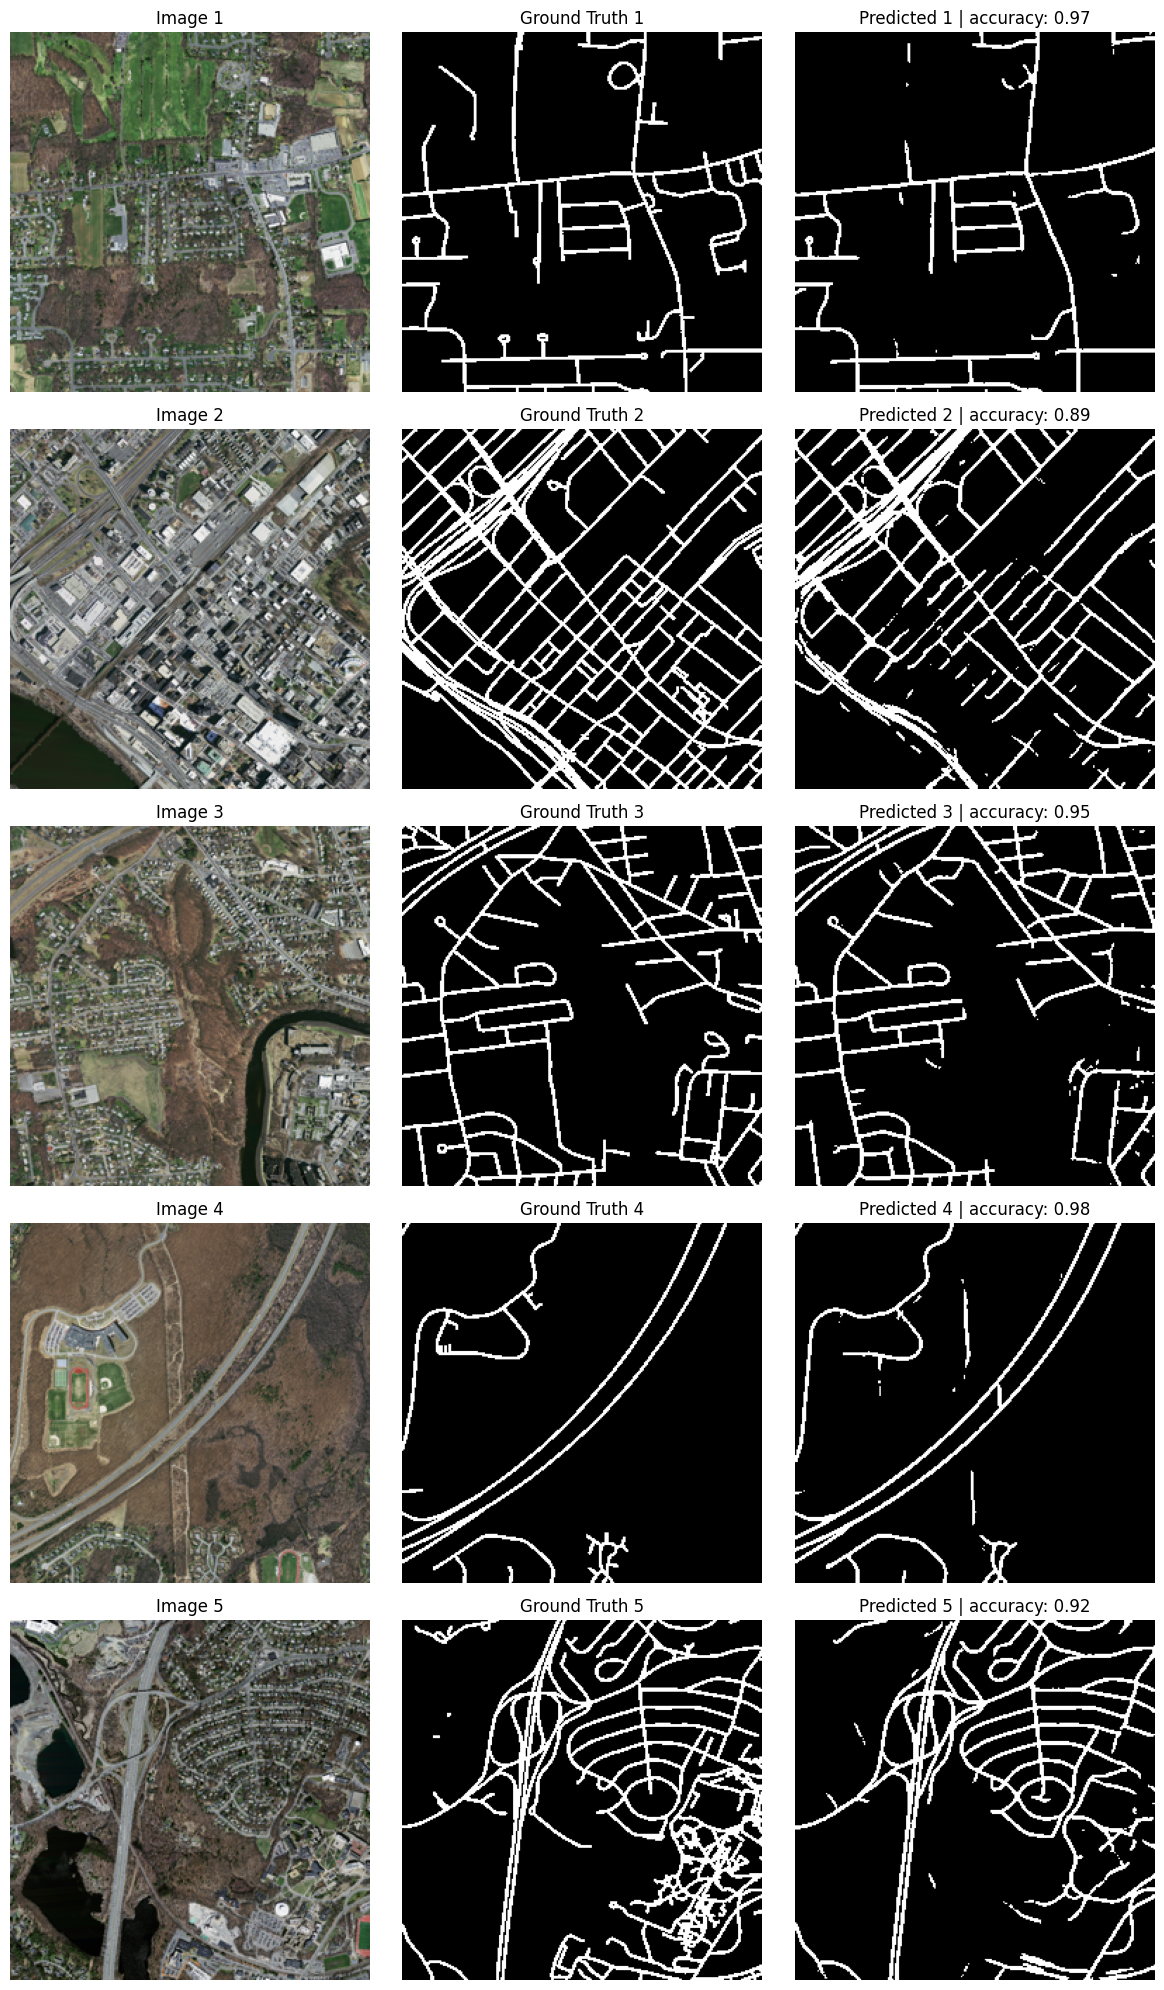

In [ ]:
def visualize_image_mask_prediction(images, masks, predictions, n=5):
    plt.figure(figsize=(12, 4 * n))

    for i in range(n):
        ...

    plt.tight_layout()
    plt.show()